In [49]:
import numpy as np
import torch
import modules.custom_metrics
from torchmetrics.classification import (
    MultilabelPrecision,
    MultilabelRecall,
    MultilabelAccuracy,
    MultilabelF1Score
)
from modules.dataloaders import (
    get_dfire_mini_test_loader,
    get_val_loader,
    get_clouds_loader,
)
from modules.brevitas.model_mobilenetv2_mini_Resnet_Brevitas import (
    MobileNetV2_MINI_RESNET
)
from modules.utils import (
    load_checkpoint
)
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

# import image_dehazer

In [2]:
# import importlib
# importlib.reload(modules.dataloaders)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device is: {DEVICE}')

Device is: cuda


# Dataloaders

In [4]:
RETURN_IMAGE_FILENAME = True
DEHAZE = False

In [5]:
dfire_mini_test = get_dfire_mini_test_loader()


TEST DFire MINI dataset
DFire Removed wrong images: 0
DFire empty images: 6
DFire only smoke images: 13
DFire only fire images: 2
DFire smoke and fire images: 9

Test dataset len: 30


In [6]:
print("================================= VAL LOADER =================================")
val_loader = get_val_loader(
    return_img_filename=RETURN_IMAGE_FILENAME,
    dehaze=DEHAZE)

================================= VAL LOADER =================================

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 1997
FASDD only smoke images: 846
FASDD only fire images: 35
FASDD smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
FASDD Removed wrong images: 0
FASDD empty images: 6533
FASDD only smoke images: 3902
FASDD only fire images: 2091
FASDD smoke and fire images: 3358

Test FASDD CV dataset len: 15884

==================== CONCATENATE
Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate with FASDD CV dataset
Test dataset len: 24371


In [7]:
print("================================= CLOUDS LOADER =================================")
clouds_loader = get_clouds_loader(
    return_img_filename=RETURN_IMAGE_FILENAME,
    dehaze=DEHAZE)

================================= CLOUDS LOADER =================================

Train CLOUDS dataset
Clouds Dataset Removed wrong images: 0

Train CLOUDS dataset len: 4043


# Models

In [8]:
mbnetv2_mini = MobileNetV2_MINI_RESNET().to(DEVICE)
mbnetv2_mini.eval();

/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/brevitas/nn/mixin/base.py:59: UserWarning: Keyword arguments are being passed but they not being used.
  warn('Keyword arguments are being passed but they not being used.')


In [9]:
model_weights = './experiments_brevitas/test_v05_mini_resnet_70k_full_ds/weights/MY_MBLNET_V2_RESNET_classifier__best_mean_F1.pt'

load_checkpoint(
    model_weights,
    mbnetv2_mini,
    device=DEVICE)

Loading Model. Trained during 91 epochs


91

### Trained with Clouds

In [10]:
mbnetv2_mini_clouds = MobileNetV2_MINI_RESNET().to(DEVICE)
mbnetv2_mini_clouds.eval();

In [11]:
model_clouds_weights = './experiments_brevitas/test_v051_mini_resnet_70k_CLOUDS_full_ds/weights/MY_MBLNET_V2_Resnet_classifier__best_mean_F1.pt'

load_checkpoint(
    model_clouds_weights,
    mbnetv2_mini_clouds,
    device=DEVICE)

Loading Model. Trained during 94 epochs


94

# Torchmetrics

In [12]:
precision_metric = MultilabelPrecision(num_labels = 2, threshold = 0.5, average = None).to(DEVICE)
recall_metric = MultilabelRecall(num_labels = 2, threshold = 0.5, average = None).to(DEVICE)
accuracy_metric = MultilabelAccuracy(num_labels = 2, threshold = 0.5, average = None).to(DEVICE)
f1_metric = MultilabelF1Score(num_labels = 2, threshold = 0.5, average = None).to(DEVICE)
f1_metric_mean = MultilabelF1Score(num_labels = 2, threshold = 0.5, average = 'macro').to(DEVICE)

# Custom Metrics

In [13]:
def get_metrics(y_pred, y_true, class_name=None):
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    n_samples = y_true.shape[0]
    #print(f'Number of test samples: {n_samples}')

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    TN = ((1 - y_pred) * (1 - y_true)).sum()
    FN = n_samples - TP - FP - TN
    assert FN == ((1 - y_pred) * y_true).sum()
    assert (TP + FP) != 0 # Avoid division by zero in Precision
    #assert y_true.sum() != 0 # Avoid division by zero in Recall -> Removed to calculate Clouds Statistics
    if y_true.sum() == 0:
        print(f'Be careful, y.true.sum() == 0 -> Check there are positive examples in the dataset')

    print(f'{class_name:<5} -> TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')

    accuracy = (TP + TN) / n_samples 
    precision =  TP / (TP + FP)  
    recall = (TP / (y_true.sum() + 1e-6)) + 1e-6 # 1e-10 for clouds recall
    f1 = (2 * precision * recall ) / ( precision + recall )
    
    return {
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4)
    }
    
def get_mean_metrics(smoke_metrics, fire_metrics):
    mean_dic = {}
    for s, f in zip(smoke_metrics.keys(), fire_metrics.keys()):
        mean_dic.update({s: round( ( smoke_metrics[s] + fire_metrics[f] ) / 2, 4)})
    return mean_dic

# Defog Image

In [54]:
def defog_image(hazed_img):
    '''
    Takes a torch.tensor image, converts to numpy uint8 and dehaze it. Transform again to torch, normalizing.
    '''
    # print(f'Hazed img shape: {hazed_img.shape}')
    hazed_img = hazed_img.permute(1, 2, 0).clone().detach().numpy()
    hazed_img = (hazed_img * 255).astype(np.uint8)
    dehazed_img, _ = image_dehazer.remove_haze(hazed_img, showHazeTransmissionMap=False)  
    
    dehazed_img = (np.expand_dims(dehazed_img, axis=0) / 255.)
    dehazed_img = torch.tensor(dehazed_img, dtype=torch.float32)
    dehazed_img = dehazed_img.permute(0, 3, 1, 2)
    
    return dehazed_img

# Validation Function

In [43]:
def eval_fn(loader, model, device, return_img_filename, dehaze):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    smoke_true = []
    smoke_pred = []
    fire_true = []
    fire_pred = []

    # Errors
    smoke_errors = []
    smoke_fp = []
    smoke_fn = []
    fire_errors = []
    fire_fp = []
    fire_fn = []


    for batch_idx, ds_items in enumerate(loop):
        if return_img_filename:
            x, y, batch_img_filename = ds_items
        else:
            x, y = ds_items

        for i in range(x.shape[0]):
            label = y[i]
            label = label.unsqueeze(0)
            if dehaze:
                image = defog_image(x[i])
            else:
                image = x[i]
                image = image.unsqueeze(0)
            image, label = image.to(device), label.to(device)    
            out = model(image)   

            # print(f'Label {y} - Pred {out}')
            yhat = torch.sigmoid(out.detach())
            precision_metric.update(yhat, label)
            recall_metric.update(yhat, label)
            accuracy_metric.update(yhat, label)
            f1_metric.update(yhat, label)
            f1_metric_mean.update(yhat, label)
    
            # Custom Metrics
            yhat[yhat >= 0.5] = 1.
            yhat[yhat < 0.5] = 0.
            # for i in range(x.shape[0]):
            smoke_yhat = yhat[0][0].item()
            fire_yhat = yhat[0][1].item()
            smoke_label = label[0][0].item()
            fire_label = label[0][1].item()
            if return_img_filename:
                img_filename = batch_img_filename[i]
                if smoke_yhat != smoke_label:
                    smoke_errors.append(img_filename)
                if fire_yhat != fire_label:
                    fire_errors.append(img_filename)    
            smoke_pred.append(smoke_yhat)
            smoke_true.append(smoke_label)
            fire_pred.append(fire_yhat)
            fire_true.append(fire_label)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    f1_mean = f1_metric_mean.compute()
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    f1_metric_mean.reset()

    # Custom Metrics
    smoke_metrics = get_metrics(smoke_pred, smoke_true, 'Smoke')
    fire_metrics = get_metrics(fire_pred, fire_true, 'Fire')
    mean_metrics = get_mean_metrics(smoke_metrics, fire_metrics)

    print("___________________________ Torchmetrics ___________________________")
    print(f'SMOKE -> Precision: {precision[0]:.4f} - Recall: {recall[0]:.4f} - Accuracy: {accuracy[0]:.4f} - F1: {f1[0]:.4f}')
    print(f'FIRE -> Precision: {precision[1]:.4f} - Recall: {recall[1]:.4f} - Accuracy: {accuracy[1]:.4f} - F1: {f1[1]:.4f}')
    print(f'F1 Mean: {f1_mean:.4f}')

    print("___________________________ Custom Metrics _________________________")
    print(f'SMOKE -> ' +
          f'Precision: {smoke_metrics["Precision"]} - ' +
          f'Recall: {smoke_metrics["Recall"]} - '+
          f'Accuracy: {smoke_metrics["Accuracy"]} - '+ 
          f'F1: {smoke_metrics["F1"]}')
    print(f'FIRE -> ' +
          f'Precision: {fire_metrics["Precision"]} - ' +
          f'Recall: {fire_metrics["Recall"]} - '+
          f'Accuracy: {fire_metrics["Accuracy"]} - '+ 
          f'F1: {fire_metrics["F1"]}')    
    print(f'F1 Mean: {mean_metrics["F1"]}')    
    
    return {
        'Torchmetrics': {
            'Accuracy': [accuracy[0].item(), accuracy[1].item()],
            'Precision': [precision[0].item(), precision[1].item()],
            'Recall': [recall[0].item(), recall[1].item()],
            'F1': [f1[0].item(), f1[1].item()],
            'F1 Mean': f1_mean.item()
        },
        'Custom Metrics': {
            'Smoke': smoke_metrics,
            'Fire': fire_metrics,
            'Mean': mean_metrics
        },
        'Errors': {
            'Smoke errors': smoke_errors,
            'Fire errors': fire_errors
        }
    }

# No Clouds Model

In [44]:
mbnetv2_mini.eval();
mbnetv2_mini.to(DEVICE);

### DFire Mini

In [55]:
dfire_mini_test_metrics = eval_fn(
    dfire_mini_test,
    mbnetv2_mini,
    DEVICE,
    return_img_filename=False,
    dehaze=True
)

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.69it/s]

Smoke -> TP: 16.0, FP: 2.0, TN: 6.0, FN: 6.0
Fire  -> TP: 11.0, FP: 3.0, TN: 16.0, FN: 0.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.8889 - Recall: 0.7273 - Accuracy: 0.7333 - F1: 0.8000
FIRE -> Precision: 0.7857 - Recall: 1.0000 - Accuracy: 0.9000 - F1: 0.8800
F1 Mean: 0.8400
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.8889 - Recall: 0.7273 - Accuracy: 0.7333 - F1: 0.8
FIRE -> Precision: 0.7857 - Recall: 1.0 - Accuracy: 0.9 - F1: 0.88
F1 Mean: 0.84


### Full Val DS

In [57]:
val_metrics_no_dehaze = eval_fn(
    val_loader,
    mbnetv2_mini,
    DEVICE,
    return_img_filename=RETURN_IMAGE_FILENAME,
    dehaze=False
)

Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [07:57<00:00,  1.26s/it]

Smoke -> TP: 10746.0, FP: 513.0, TN: 12342.0, FN: 719.0
Fire  -> TP: 7740.0, FP: 477.0, TN: 15959.0, FN: 144.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.9544 - Recall: 0.9373 - Accuracy: 0.9493 - F1: 0.9458
FIRE -> Precision: 0.9419 - Recall: 0.9817 - Accuracy: 0.9745 - F1: 0.9614
F1 Mean: 0.9536
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.9544 - Recall: 0.9373 - Accuracy: 0.9493 - F1: 0.9458
FIRE -> Precision: 0.9419 - Recall: 0.9817 - Accuracy: 0.9745 - F1: 0.9614
F1 Mean: 0.9536


In [56]:
val_metrics = eval_fn(
    val_loader,
    mbnetv2_mini,
    DEVICE,
    return_img_filename=RETURN_IMAGE_FILENAME,
    dehaze=True
)

Validating:   1%|█▊                                                                                                                                          | 5/380 [00:17<21:43,  3.48s/it]/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/image_dehazer/__init__.py:35: RuntimeWarning: divide by zero encountered in divide
  t_b = np.maximum((self._A[0] - HazeImg[:, :, 0].astype(float)) / (self._A[0] - self.C0),
/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/image_dehazer/__init__.py:35: RuntimeWarning: invalid value encountered in divide
  t_b = np.maximum((self._A[0] - HazeImg[:, :, 0].astype(float)) / (self._A[0] - self.C0),
/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/image_dehazer/__init__.py:167: RuntimeWarning: invalid value encountered in cast
  HazeCorrectedImage[:, :, ch] = temp
Validating:   3%|███▋                                                                                                                                       | 10/380 [00:34<21

Smoke -> TP: 8992.0, FP: 545.0, TN: 12310.0, FN: 2473.0
Fire  -> TP: 7610.0, FP: 754.0, TN: 15682.0, FN: 274.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.9430 - Recall: 0.7843 - Accuracy: 0.8759 - F1: 0.8563
FIRE -> Precision: 0.9099 - Recall: 0.9652 - Accuracy: 0.9577 - F1: 0.9367
F1 Mean: 0.8965
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.9429 - Recall: 0.7843 - Accuracy: 0.8759 - F1: 0.8563
FIRE -> Precision: 0.9099 - Recall: 0.9652 - Accuracy: 0.9577 - F1: 0.9367
F1 Mean: 0.8965


### Clouds DS

In [45]:
clouds_metrics = eval_fn(
    clouds_loader,
    mbnetv2_mini,
    DEVICE,
    return_img_filename=RETURN_IMAGE_FILENAME,
    dehaze=False
)

Validating:   0%|                                                                                                                                                   | 0/4043 [00:00<?, ?it/s]/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/pooling.py:641: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.avg_pool2d(input, self.kernel_size, self.

Be careful, y.true.sum() == 0 -> Check there are positive examples in the dataset
Smoke -> TP: 0.0, FP: 220.0, TN: 3823.0, FN: 0.0
Be careful, y.true.sum() == 0 -> Check there are positive examples in the dataset
Fire  -> TP: 0.0, FP: 8.0, TN: 4035.0, FN: 0.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.0000 - Recall: 0.0000 - Accuracy: 0.9456 - F1: 0.0000
FIRE -> Precision: 0.0000 - Recall: 0.0000 - Accuracy: 0.9980 - F1: 0.0000
F1 Mean: 0.0000
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.0 - Recall: 0.0 - Accuracy: 0.9456 - F1: 0.0
FIRE -> Precision: 0.0 - Recall: 0.0 - Accuracy: 0.998 - F1: 0.0
F1 Mean: 0.0


# Clouds Model

In [19]:
mbnetv2_mini_clouds.eval();
mbnetv2_mini_clouds.to(DEVICE);

### DFire Mini

In [20]:
cloud_model_dfire_mini_test_metrics = eval_fn(
    dfire_mini_test,
    mbnetv2_mini_clouds,
    DEVICE,
    return_img_filename=False
)

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.30it/s]

Smoke -> TP: 22.0, FP: 0.0, TN: 8.0, FN: 0.0
Fire  -> TP: 11.0, FP: 1.0, TN: 18.0, FN: 0.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 1.0000 - Recall: 1.0000 - Accuracy: 1.0000 - F1: 1.0000
FIRE -> Precision: 0.9167 - Recall: 1.0000 - Accuracy: 0.9667 - F1: 0.9565
F1 Mean: 0.9783
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 1.0 - Recall: 1.0 - Accuracy: 1.0 - F1: 1.0
FIRE -> Precision: 0.9167 - Recall: 1.0 - Accuracy: 0.9667 - F1: 0.9565
F1 Mean: 0.9782


### Full Val DS

In [21]:
cloud_model_val_metrics = eval_fn(
    val_loader,
    mbnetv2_mini_clouds,
    DEVICE,
    return_img_filename=RETURN_IMAGE_FILENAME
)

Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:25<00:00, 14.93it/s]

Smoke -> TP: 10729.0, FP: 633.0, TN: 12222.0, FN: 736.0
Fire  -> TP: 7712.0, FP: 482.0, TN: 15954.0, FN: 172.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.9443 - Recall: 0.9358 - Accuracy: 0.9437 - F1: 0.9400
FIRE -> Precision: 0.9412 - Recall: 0.9782 - Accuracy: 0.9731 - F1: 0.9593
F1 Mean: 0.9497
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.9443 - Recall: 0.9358 - Accuracy: 0.9437 - F1: 0.94
FIRE -> Precision: 0.9412 - Recall: 0.9782 - Accuracy: 0.9731 - F1: 0.9593
F1 Mean: 0.9496


### Clouds DS

In [22]:
cloud_model_clouds_metrics = eval_fn(
    clouds_loader,
    mbnetv2_mini_clouds,
    DEVICE,
    return_img_filename=RETURN_IMAGE_FILENAME
)

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4043/4043 [01:27<00:00, 46.47it/s]

Be careful, y.true.sum() == 0 -> Check there are positive examples in the dataset
Smoke -> TP: 0.0, FP: 30.0, TN: 4013.0, FN: 0.0
Be careful, y.true.sum() == 0 -> Check there are positive examples in the dataset
Fire  -> TP: 0.0, FP: 1.0, TN: 4042.0, FN: 0.0
___________________________ Torchmetrics ___________________________
SMOKE -> Precision: 0.0000 - Recall: 0.0000 - Accuracy: 0.9926 - F1: 0.0000
FIRE -> Precision: 0.0000 - Recall: 0.0000 - Accuracy: 0.9998 - F1: 0.0000
F1 Mean: 0.0000
___________________________ Custom Metrics _________________________
SMOKE -> Precision: 0.0 - Recall: 0.0 - Accuracy: 0.9926 - F1: 0.0
FIRE -> Precision: 0.0 - Recall: 0.0 - Accuracy: 0.9998 - F1: 0.0
F1 Mean: 0.0


# Check Errors

In [23]:
def plot_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

    plt.imshow(img)
    plt.show()

In [58]:
IMGS_CHECK = 10

In [60]:
print(len(val_metrics_no_dehaze["Errors"]["Smoke errors"]))
for img in val_metrics_no_dehaze["Errors"]["Smoke errors"][:IMGS_CHECK]:
    print(img)

1232
../../datasets/ds2fire/dfire_yolo/test/images/AoF06742.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06764.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06773.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06803.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06937.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06943.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06967.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06983.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF06994.jpg
../../datasets/ds2fire/dfire_yolo/test/images/AoF07027.jpg


In [26]:
for img in clouds_metrics["Errors"]["Smoke errors"][:IMGS_CHECK]:
    print(img)

../../datasets/clouds/images/clouds_1500__1005.jpg
../../datasets/clouds/images/clouds_1500__1033.jpg
../../datasets/clouds/images/clouds_1500__1054.jpg
../../datasets/clouds/images/clouds_1500__1062.jpg
../../datasets/clouds/images/clouds_1500__1087.jpg
../../datasets/clouds/images/clouds_1500__109.jpg
../../datasets/clouds/images/clouds_1500__1146.jpg
../../datasets/clouds/images/clouds_1500__1204.jpg
../../datasets/clouds/images/clouds_1500__1213.jpg
../../datasets/clouds/images/clouds_1500__1219.jpg


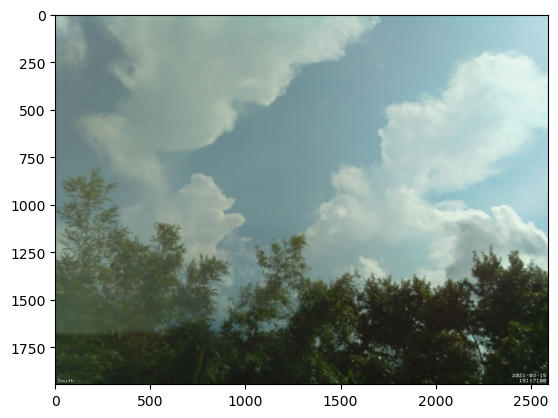

In [27]:
plot_img(clouds_metrics["Errors"]["Smoke errors"][0])

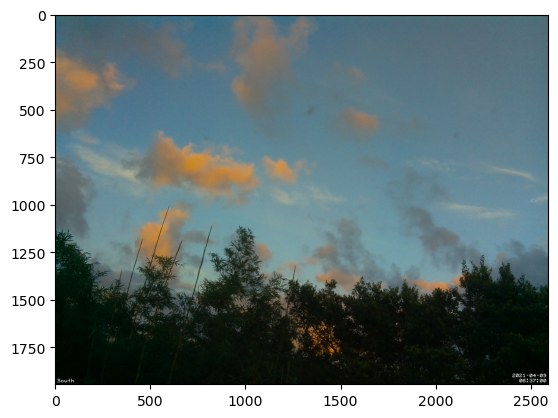

In [28]:
plot_img(cloud_model_clouds_metrics["Errors"]["Smoke errors"][0])

# Matching errors in No Clouds and Clouds

In [29]:
matching_errors = []
for no_cloud_errors in clouds_metrics["Errors"]["Smoke errors"]:
    if no_cloud_errors in cloud_model_clouds_metrics["Errors"]["Smoke errors"]:
        matching_errors.append(no_cloud_errors)

In [30]:
matching_errors

['../../datasets/clouds/images/clouds_1500__61.jpg',
 '../../datasets/clouds/images/clouds_kaggle__1655.jpg',
 '../../datasets/clouds/images/clouds_kaggle__1678.jpg',
 '../../datasets/clouds/images/clouds_kaggle__1755.jpg',
 '../../datasets/clouds/images/clouds_kaggle__1933.jpg',
 '../../datasets/clouds/images/clouds_kaggle__1979.jpg',
 '../../datasets/clouds/images/clouds_kaggle__198.jpg',
 '../../datasets/clouds/images/clouds_kaggle__2145.jpg',
 '../../datasets/clouds/images/clouds_kaggle__2176.jpg',
 '../../datasets/clouds/images/clouds_kaggle__2318.jpg',
 '../../datasets/clouds/images/clouds_kaggle__2443.jpg',
 '../../datasets/clouds/images/clouds_kaggle__2495.jpg',
 '../../datasets/clouds/images/clouds_kaggle__254.jpg',
 '../../datasets/clouds/images/clouds_kaggle__268.jpg',
 '../../datasets/clouds/images/clouds_kaggle__354.jpg',
 '../../datasets/clouds/images/clouds_kaggle__743.jpg',
 '../../datasets/clouds/images/clouds_kaggle__838.jpg']

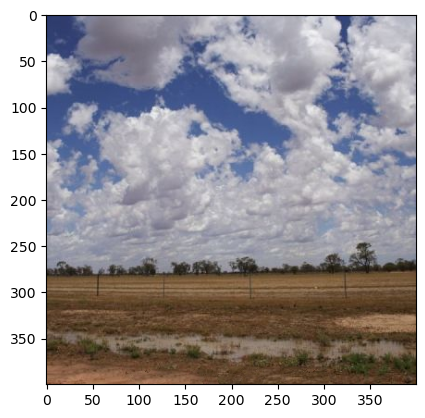

In [31]:
plot_img(matching_errors[11])